## Imports

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from moviepy.editor import VideoFileClip
%matplotlib inline


## Camera calibration

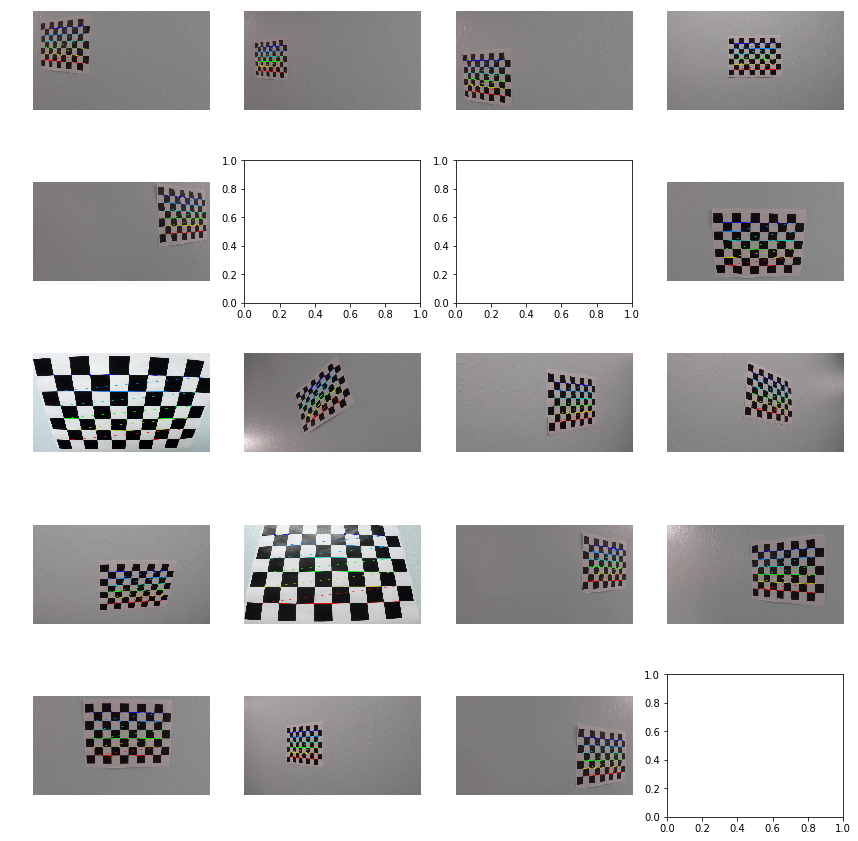

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

fig, ax = plt.subplots(5,4)
fig.subplots_adjust(right=2, top=3)
ax = ax.ravel()

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)
        ax[idx].axis('off')
        ax[idx].imshow(img)

#cv2.destroyAllWindows()

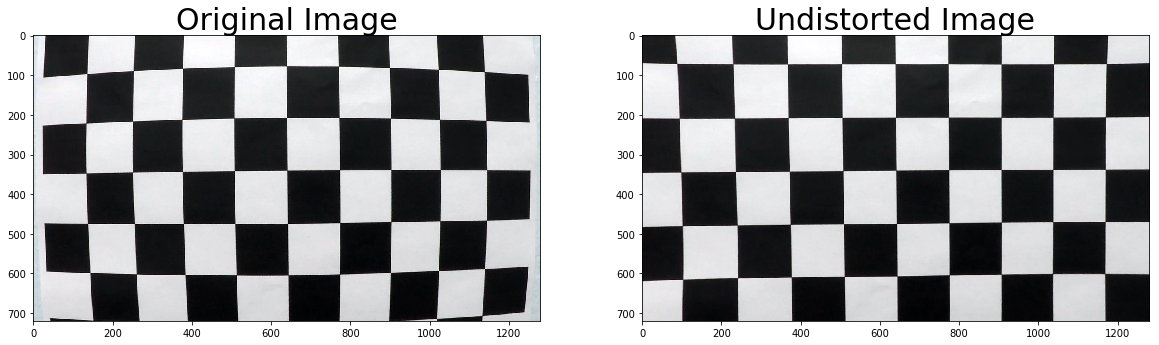

In [3]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Distortion correction on test images

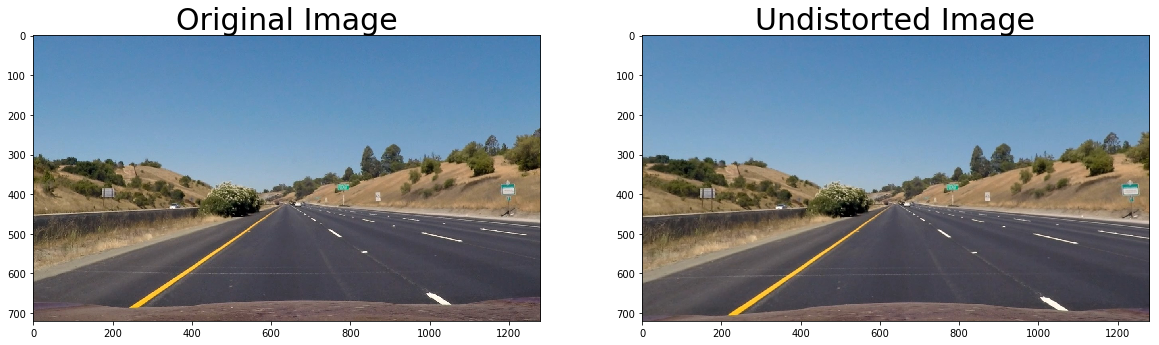

In [4]:
test_images = glob.glob('test_images/*.jpg')
undist_images = []

for idx, fname in enumerate(test_images):
    test_img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    test_dst = cv2.undistort(test_img, mtx, dist, None, mtx)
    undist_images.append(test_dst)

# Visualize undistortion
test_img1 = cv2.cvtColor(cv2.imread('test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img1)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_images[0])
ax2.set_title('Undistorted Image', fontsize=30)

## Create binary image

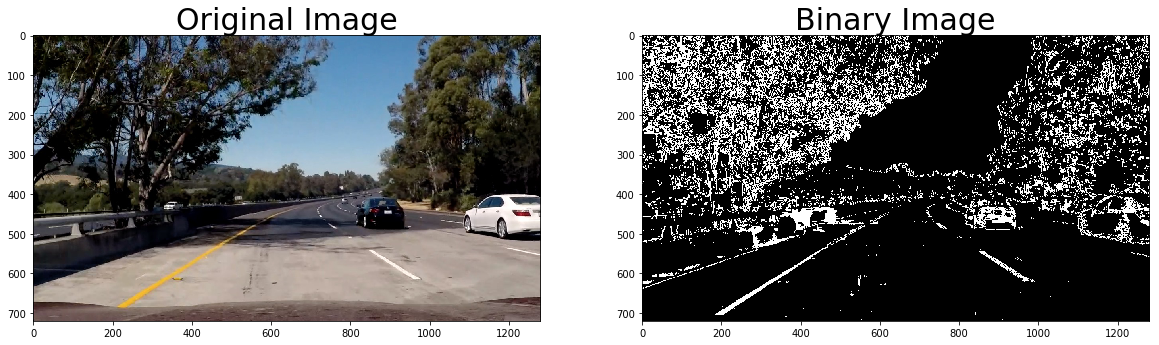

In [42]:
def create_binary_image(undist_img):
    s_thresh=(170, 255)
    sx_thresh=(20, 100)
    mag_thresh=(30, 100)
    grad_thresh=(0, np.pi/2)
    
    img_hls = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS)
    l_channel = img_hls[:,:,1]
    s_channel = img_hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
    # Sobel y
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1) # Take the derivative in x
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    # Threshold x gradient
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= sx_thresh[0]) & (scaled_sobely <= sx_thresh[1])] = 1
    
    sbinary = np.zeros_like(s_channel)
    sbinary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    
    gradmag = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    gradmag_sobel = np.uint8(255*gradmag/np.max(gradmag))
    gradmag_binary = np.zeros_like(gradmag_sobel)
    gradmag_binary[(gradmag_sobel >= mag_thresh[0]) & (gradmag_sobel <= mag_thresh[1])] = 1
    
    
    grad_direct = np.arctan2(abs_sobely, abs_sobelx)
    direct_binary = np.zeros_like(grad_direct)
    direct_binary[(grad_direct >= grad_thresh[0]) & (grad_direct <= grad_thresh[1])] = 1
    
    
    binary_img = np.zeros_like(sxbinary)
    #binary_img[((sxbinary==1) & (sybinary==1)) | ((gradmag_binary==1) & (direct_binary==1))] = 1 # = np.dstack(( np.zeros_like(sxbinary), sxbinary, sbinary)) * 255
    binary_img[(sxbinary==1) | (sbinary==1)] = 1
    return binary_img



binary_images = []
for idx, undist_img in enumerate(undist_images):
    binary_img = create_binary_image(undist_img)
    binary_images.append(binary_img)

# Visualize binary image
test_img1 = cv2.cvtColor(cv2.imread('test_images/test5.jpg'), cv2.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img1)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_images[7], cmap='gray')
ax2.set_title('Binary Image', fontsize=30)

## Perspective transform

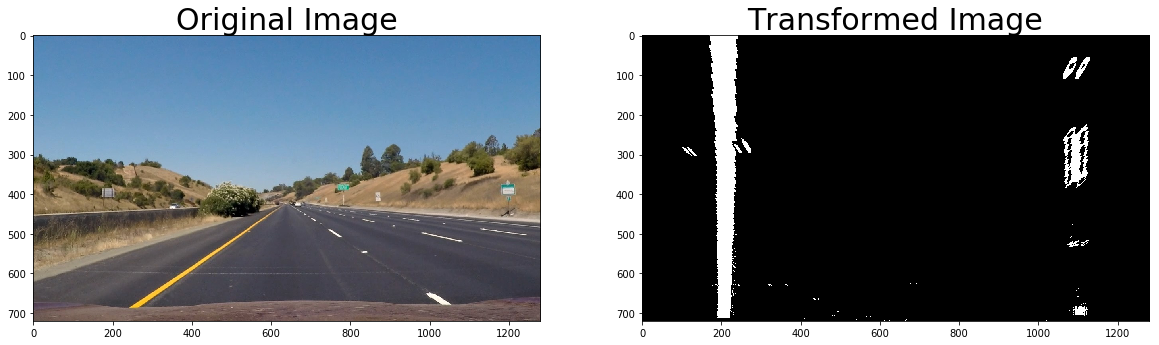

In [6]:
def warp_image(bin_img):
    img_size = (bin_img.shape[1], bin_img.shape[0])
    src = np.float32([(220,720), (570,470), (720,470), (1110,720)])
    dst = np.float32([(220,720), (220,0), (1110,0), (1110,720)])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_img = cv2.warpPerspective(bin_img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped_img, Minv


warped_images = []

for idx, bin_img in enumerate(binary_images):
    #img_size = (bin_img.shape[1], bin_img.shape[0])
    #src = np.float32([(220,720), (570,470), (720,470), (1110,720)])
    #dst = np.float32([(220,720), (220,0), (1110,0), (1110,720)])
    #M = cv2.getPerspectiveTransform(src, dst)
    #warped_img = cv2.warpPerspective(bin_img, M, img_size, flags=cv2.INTER_LINEAR)
    warped_img, Minv = warp_image(bin_img)
    warped_images.append(warped_img)

# Visualize binary image
test_img1 = cv2.cvtColor(cv2.imread('test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img1)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_images[0], cmap='gray')
ax2.set_title('Transformed Image', fontsize=30)

## Sliding window and polyfit

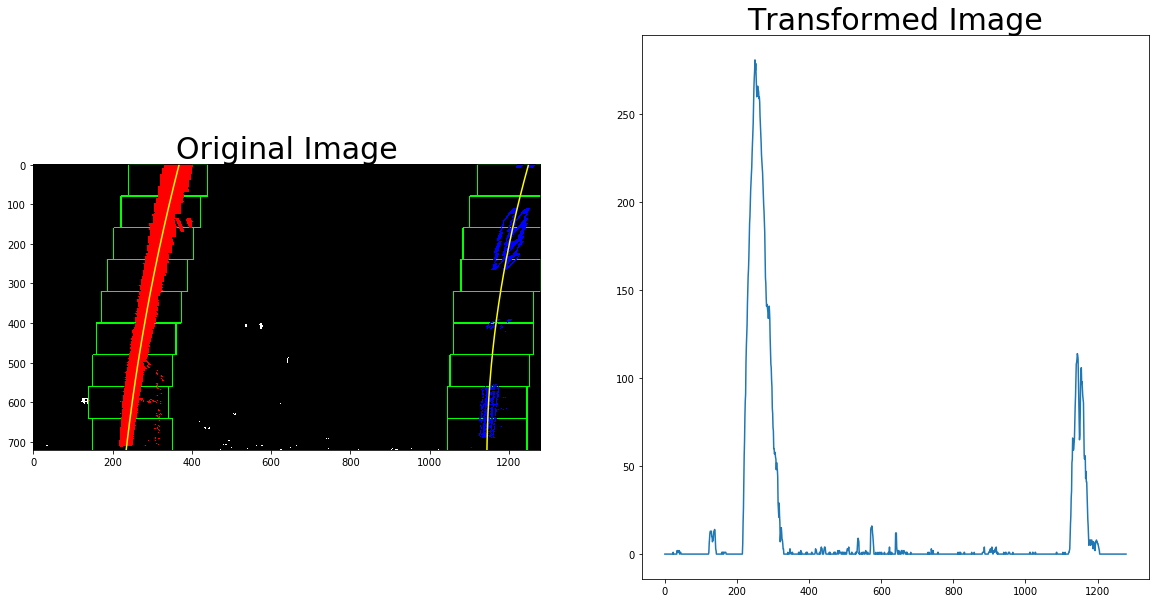

In [7]:
binary_warped = warped_images[2]


def sliding_windows_and_ployfit(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return left_fit, right_fit, left_fitx, right_fitx, left_lane_inds, right_lane_inds, out_img, ploty, histogram
#plt.imshow(out_img)
#plt.plot(left_fitx, ploty, color='yellow')
#plt.plot(right_fitx, ploty, color='yellow')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)

left_fit, right_fit, left_fitx, right_fitx, left_lane_inds, right_lane_inds, out_img, ploty, histogram = sliding_windows_and_ployfit(binary_warped)

# Visualize binary image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(out_img)
ax1.plot(left_fitx, ploty, color='yellow')
ax1.plot(right_fitx, ploty, color='yellow')
ax1.set_title('Original Image', fontsize=30)
ax2.plot(histogram)
ax2.set_title('Transformed Image', fontsize=30)

## Use fit from previous frame

(720, 0)

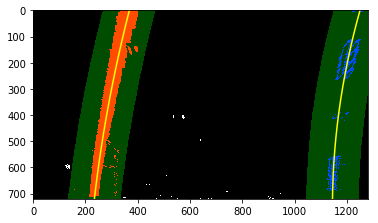

In [8]:
def fit_from_previous_frame(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    return left_fit, right_fit, left_fitx, right_fitx, left_line_pts, right_line_pts, out_img, ploty

# Draw the lane onto the warped blank image
left_fit, right_fit, left_fitx, right_fitx, left_line_pts, right_line_pts, out_img, ploty = fit_from_previous_frame(binary_warped, left_fit, right_fit)
window_img = np.zeros_like(out_img)
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


## Radius of curvature

In [11]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/900 # meters per pixel in x dimension

y_eval = np.max(ploty)

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

2141.94986765 m 1137.02634781 m


## Center offset

In [12]:
car_position = binary_warped.shape[1]/2
l_fit_x_int = left_fit[0]*binary_warped.shape[0]**2 + left_fit[1]*binary_warped.shape[0] + left_fit[2]
r_fit_x_int = right_fit[0]*binary_warped.shape[0]**2 + right_fit[1]*binary_warped.shape[0] + right_fit[2]
lane_center_position = (r_fit_x_int + l_fit_x_int) /2
center_offset = (car_position - lane_center_position) * xm_per_pix

print('Center offset: ', center_offset, 'm')

Center offset:  -0.203993499544 m


## Show lane area

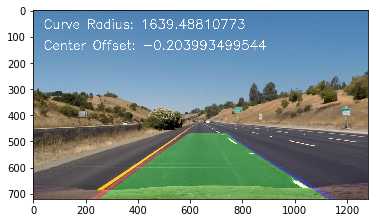

In [14]:
test_img1 = cv2.cvtColor(cv2.imread('test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)
#Minv = cv2.getPerspectiveTransform(dst, src)

# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=30)
cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=30)

#cv2.putText(color_warp,'Curve Radius: '+str((left_curverad+right_curverad)/2),(40,70), cv2.FONT_HERSHEY_SIMPLEX, 1.6,(255,255,255),2,cv2.LINE_AA)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(test_img1, 1, newwarp, 0.3, 0)
cv2.putText(result,'Curve Radius: '+str((left_curverad+right_curverad)/2),(40,70), cv2.FONT_HERSHEY_SIMPLEX, 1.6,(255,255,255),2,cv2.LINE_AA)
cv2.putText(result,'Center Offset: '+str(center_offset),(40,150), cv2.FONT_HERSHEY_SIMPLEX, 1.6,(255,255,255),2,cv2.LINE_AA)
plt.imshow(result)

## Video pipeline

In [15]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None


In [34]:
def process_video(img):
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    binary_img = create_binary_image(undist_img)
    
    warped_img, Minv = warp_image(binary_img)
    
    if not l_line.detected or not r_line.detected:
        left_fit, right_fit, left_fitx, right_fitx, left_lane_inds, right_lane_inds, out_img, ploty, histogram = sliding_windows_and_ployfit(warped_img)
    else:
        left_fit, right_fit, left_fitx, right_fitx, left_line_pts, right_line_pts, out_img, ploty = fit_from_previous_frame(warped_img, l_line.best_fit, r_line.best_fit)
        
    if left_fit is not None:
        l_line.detected = True
        l_line.best_fit = left_fit
    else:
        l_line.detected = False
        
    if right_fit is not None:
        r_line.detected = True
        r_line.best_fit = right_fit
    else:
        r_line.detected = False
    
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped_img.shape[1], warped_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return result

In [37]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(process_video)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 12%|█▏        | 152/1261 [00:22<02:44,  6.73it/s]


 24%|██▍       | 303/1261 [00:44<02:31,  6.34it/s]


 36%|███▌      | 454/1261 [01:07<02:04,  6.48it/s]


 48%|████▊     | 605/1261 [01:30<01:36,  6.78it/s]


 60%|█████▉    | 756/1261 [01:53<01:14,  6.79it/s]


 72%|███████▏  | 907/1261 [02:16<00:54,  6.51it/s]


 84%|████████▍ | 1057/1261 [02:39<00:32,  6.30it/s]


 96%|█████████▌| 1205/1261 [03:03<00:08,  6.34it/s]


100%|█████████▉| 1260/1261 [03:12<00:00,  6.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 7min 15s, sys: 2.63 s, total: 7min 18s
Wall time: 3min 13s
